# Testing bias metrics and mitigation algorithms on the German Credit dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.datasets import GermanDataset
from utility import *
from Sampler import Sampler
from matplotlib.gridspec import GridSpec
import os

path = 'imgs/german'

## Dataset description

This dataset classifies people described by a set of attributes as good or bad credit risks. The dataset consists of 1000 instances and 20 features. `age` and `sex` are the sensitive attributes. The dataset is bias w.r.t. women with age < 25.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [2]:
german = GermanDataset()
german.labels[german.labels == 2] = 0
german.unfavorable_label = 0

In [3]:
df = german.convert_to_dataframe()[0]
df

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


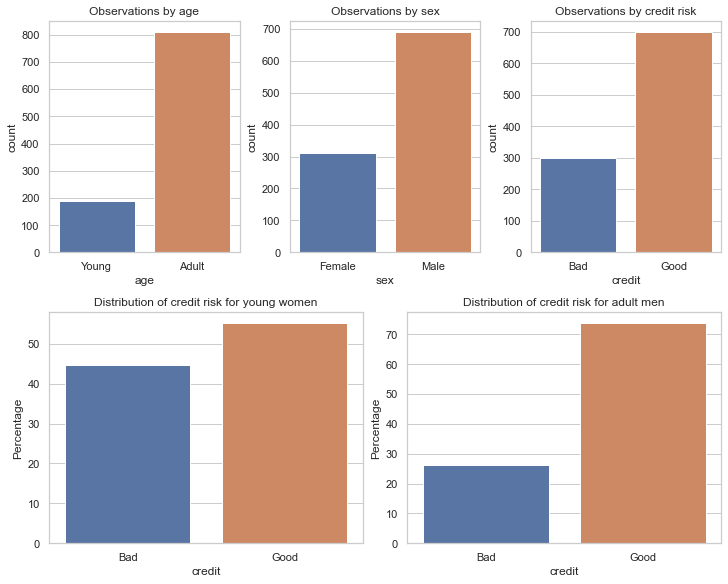

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(10,8))
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])
#fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,5))
sns.countplot(x='age', data=df, ax=ax1)
ax1.set_xticklabels(['Young','Adult'])
ax1.set_title('Observations by age')
sns.countplot(x='sex', data=df, ax=ax2)
ax2.set_xticklabels(['Female', 'Male'])
ax2.set_title('Observations by sex')
sns.countplot(x='credit', data=df, ax=ax3)
ax3.set_xticklabels(['Bad', 'Good'])
ax3.set_title('Observations by credit risk')
#plt.savefig(os.path.join(path, 'german_multi_vars.pdf'))
perc = (df[['sex','age','credit']]
        .groupby(['sex','age'])['credit']
        .value_counts(normalize=True)
        .mul(100).rename('Percentage')
        .reset_index()
       )
#fig.suptitle("Distribution of single variables")
#fig, [ax4, ax5] = plt.subplots(1,2, figsize=(15,5))
sns.barplot(data=perc[(perc['sex']==0)&(perc['age']==0)], x='credit', y='Percentage', ax=ax4)
ax4.set_xticklabels(['Bad', 'Good'])
ax4.set_title('Distribution of credit risk for young women')
sns.barplot(data=perc[(perc['sex']==1)&(perc['age']==1)], x='credit', y='Percentage', ax=ax5)
ax5.set_xticklabels(['Bad', 'Good'])
ax5.set_title('Distribution of credit risk for adult men')
#fig.suptitle("Distribution of credit risk by sensitive groups")
plt.savefig(os.path.join(path, 'german_multi_counts.pdf'))
plt.show()

In [5]:
priv_group = [{'age':1, 'sex':1}]
unpriv_group = [{'age':0, 'sex':0}]

# Bias dataset case

### Dataset Metrics:

Disparate Impact: 0.7475
Statistical Parity: -0.1865




### Classification Metrics:

Balanced accuracy: 0.7095
Statistical parity: -0.2656
Disparate impact: 0.6038
Average odds: -0.1827
Equal opportunity: -0.1819
Theil index: 0.2539


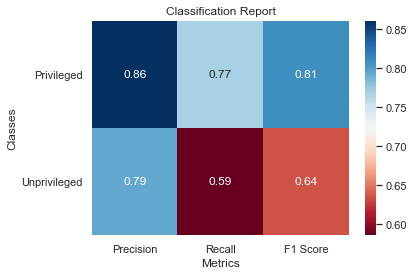

In [6]:
bias_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    german, priv_group, unpriv_group)

# Reweighing

In [7]:
rw_data = german.copy()
rw = Reweighing(unpriv_group, priv_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7070
Statistical parity: -0.1374
Disparate impact: 0.7834
Average odds: -0.0691
Equal opportunity: 0.0064
Theil index: 0.2629


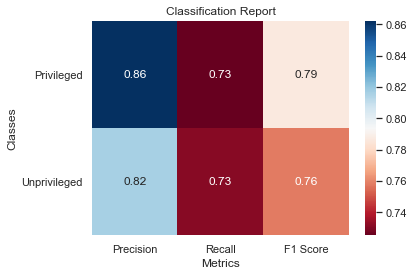

In [8]:
rw_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_data, priv_group, unpriv_group, debiaser=rw)

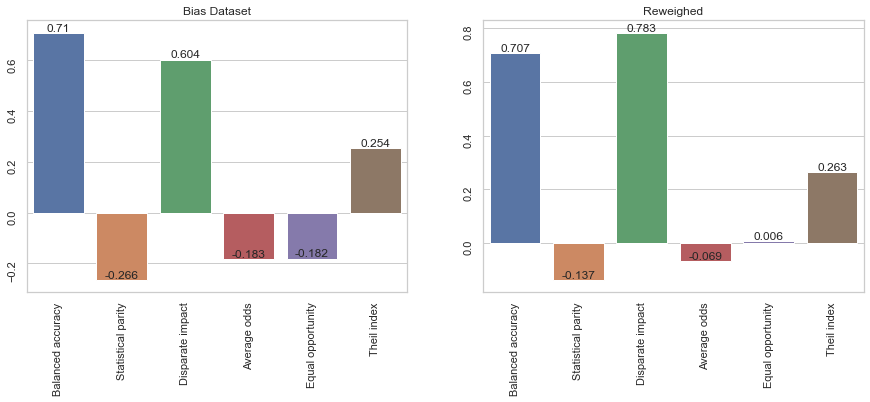

In [9]:
plot_metrics_comparison(bias_class, rw_class, 'Bias Dataset', 'Reweighed')
plt.show()

# Modified Reweighing (Sampling)

In [10]:
sampler = Sampler(round_level=1)
sampled_data = german.copy()

### Dataset Metrics:

Disparate Impact: 0.9515
Statistical Parity: -0.0349




### Classification Metrics:

Balanced accuracy: 0.6926
Statistical parity: -0.0920
Disparate impact: 0.8501
Average odds: -0.0519
Equal opportunity: -0.0179
Theil index: 0.2784


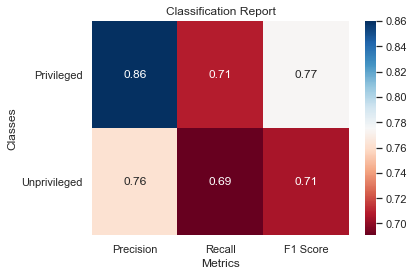

In [11]:
sampled_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_data, priv_group, unpriv_group, debiaser=sampler, n_splits=5)

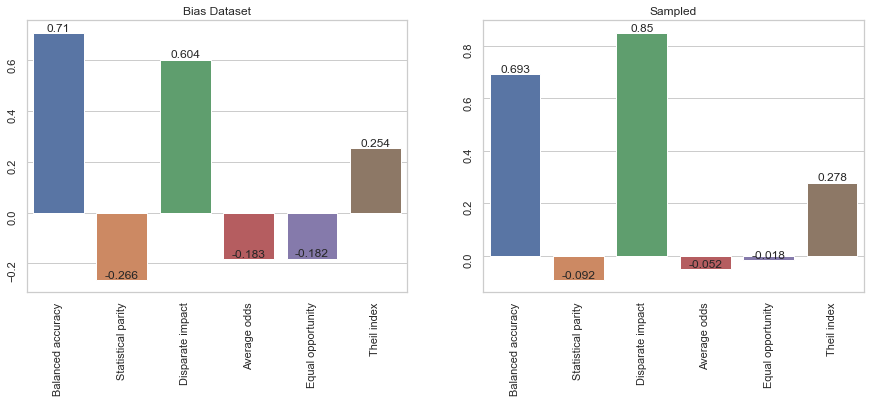

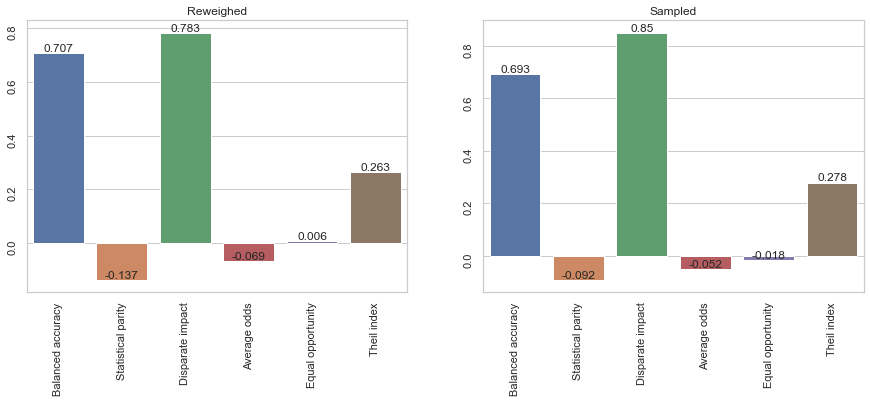

In [12]:
plot_metrics_comparison(bias_class, sampled_class, 'Bias Dataset', 'Sampled')
plot_metrics_comparison(rw_class, sampled_class, 'Reweighed', 'Sampled')
plt.show()

# Disparate Impact Remover

In [13]:
dir_data = german.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)
df = dir_data.convert_to_dataframe()[0]

In [14]:
probs = (
    df.value_counts(["sex", "age"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='age', value_name='probs'))

for sex,age,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['age'] == age), 'prob'] = prob

df.drop(df[['sex','age']], axis=1, inplace=True)

di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df = df, label_names=['credit'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

df_dir = dir_data.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.105, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1
df_dir.loc[df_dir['prob'].round(6) == 0.105, 'prob'] = 0
df_dir.loc[df_dir['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir_data = BinaryLabelDataset(df = df_dir, label_names=['credit'], protected_attribute_names=['prob'])

### Dataset Metrics:

Disparate Impact: 0.7702
Statistical Parity: -0.1649




### Classification Metrics:

Balanced accuracy: 0.7052
Statistical parity: -0.1378
Disparate impact: 0.7806
Average odds: -0.0910
Equal opportunity: -0.0288
Theil index: 0.2558


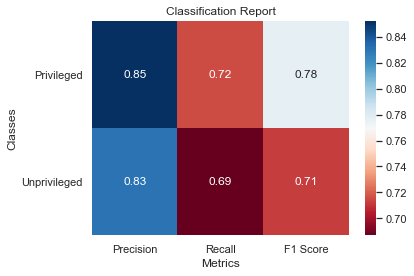

In [15]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_data, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


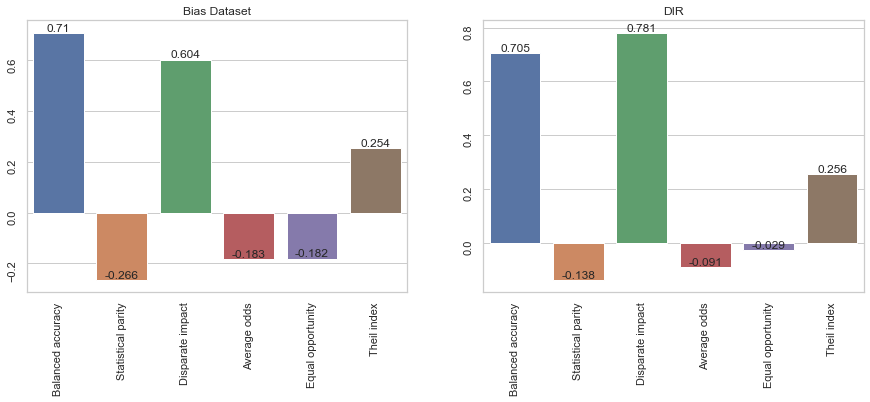

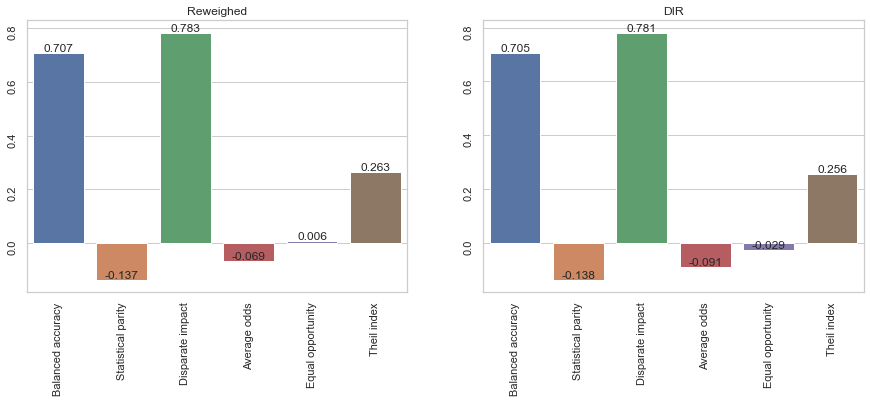

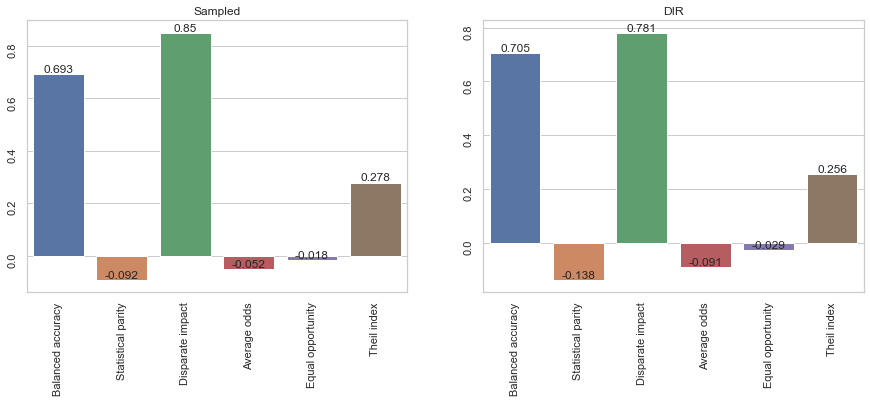

In [16]:
plot_metrics_comparison(bias_class, dir_class, 'Bias Dataset', 'DIR')
plot_metrics_comparison(rw_class, dir_class, 'Reweighed', 'DIR')
plot_metrics_comparison(sampled_class, dir_class, 'Sampled', 'DIR')
plt.show()

# Sampled prob

In [22]:
sampled_prob = BinaryLabelDataset(df=df, label_names=['credit'], protected_attribute_names=['prob'])
sampler = Sampler(round_level=1)

### Dataset Metrics:

Disparate Impact: 0.9577
Statistical Parity: -0.0302




### Classification Metrics:

Balanced accuracy: 0.7118
Statistical parity: -0.1010
Disparate impact: 0.8359
Average odds: -0.0397
Equal opportunity: -0.0017
Theil index: 0.2467


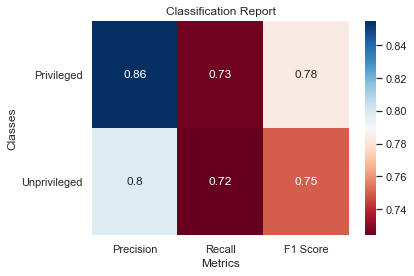

In [23]:
sampled_prob_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_prob, prob_priv_group, prob_unpriv_group, debiaser=sampler, n_splits=5)

# Reweighing + DIR

In [19]:
rw = Reweighing(prob_unpriv_group, prob_priv_group)
rw_dir = dir_data.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7143
Statistical parity: -0.1553
Disparate impact: 0.7484
Average odds: -0.0849
Equal opportunity: -0.0990
Theil index: 0.2580


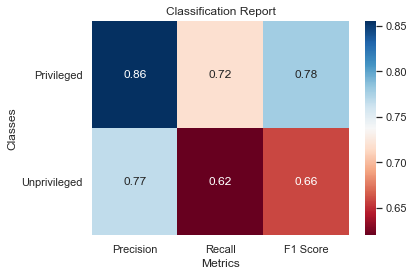

In [20]:
rw_dir_class = classify( make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'], debiaser=rw)

# Algorithms comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.1827,0.7095,0.6038,-0.1819,-0.2656,0.2539
Classic Sampling with flag variable,-0.0397,0.7118,0.8359,-0.0017,-0.1010,0.2467
DEMV,-0.0519,0.6926,0.8501,-0.0179,-0.0920,0.2784
DIR,-0.0910,0.7052,0.7806,-0.0288,-0.1378,0.2558
Reweighed,-0.0691,0.7070,0.7834,0.0064,-0.1374,0.2629
Reweighing + DIR,-0.0849,0.7143,0.7484,-0.0990,-0.1553,0.2580


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


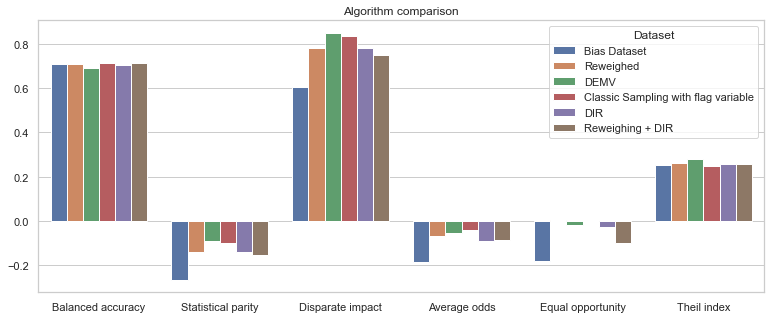

In [25]:
plot_syntesis(merge_datasets({
    'Bias Dataset': bias_class,
    'Reweighed': rw_class,
    'DEMV': sampled_class,
    'Classic Sampling with flag variable': sampled_prob_metrics,
    'DIR': dir_class,
    'Reweighing + DIR': rw_dir_class,
}), 'Algorithm comparison')
plt.savefig(os.path.join(path, 'german_multi_syn.pdf'))
plt.show()

# Case with single sensitive attribute

In [3]:
german = GermanDataset(protected_attribute_names=['age'], privileged_classes=[lambda x: x>25], features_to_drop=['sex', 'personal_status'])

In [4]:
german.labels[german.labels == 2] = 0
german.unfavorable_label = 0

In [5]:
privileged_attr = [{'age': 1}]
unpriv_attr = [{'age': 0}]

In [6]:
df = german.convert_to_dataframe()[0]

In [7]:
df

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


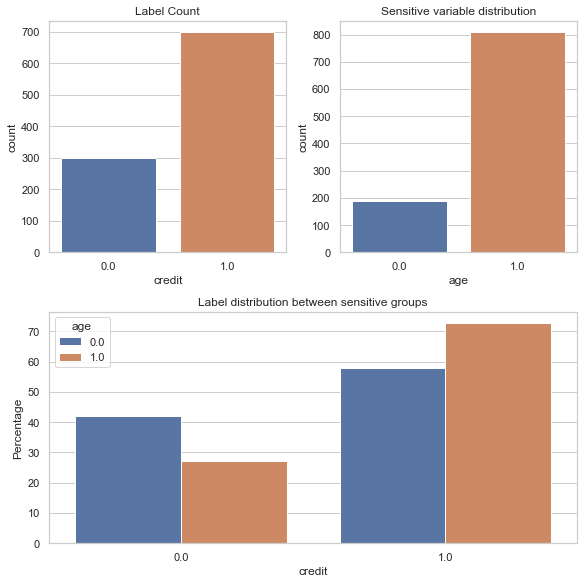

In [27]:
fig = plt.figure(constrained_layout=True, figsize=(8,8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
sns.countplot(data=df, x='credit', ax=ax1)
ax1.set_title('Label Count')
sns.countplot(data=df, x='age', ax=ax2)
ax2.set_title('Sensitive variable distribution')
#ax2.set_xticklabels(['Young','Adult'])
sns.barplot(data=(df
                  .groupby('age')['credit']
                  .value_counts(normalize=True)
                  .mul(100)
                  .rename('Percentage')
                  .reset_index()
                 ), x='credit', y='Percentage', hue='age')
ax3.set_title('Label distribution between sensitive groups')
plt.savefig(os.path.join(path, 'german_single_counts.pdf'))
plt.show()

## Bias Dataset case

### Dataset Metrics:

Disparate Impact: 0.7952
Statistical Parity: -0.1494




### Classification Metrics:

Balanced accuracy: 0.7130
Statistical parity: -0.2469
Disparate impact: 0.6158
Average odds: -0.1738
Equal opportunity: -0.2406
Theil index: 0.2593


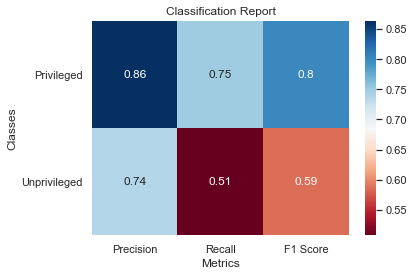

In [7]:
bias1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    german, privileged_attr, unpriv_attr)

## Reweighing

In [8]:
rw1_data = german.copy()
rw = Reweighing(unpriv_attr, privileged_attr)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7037
Statistical parity: -0.0909
Disparate impact: 0.8641
Average odds: 0.0080
Equal opportunity: -0.0480
Theil index: 0.2571


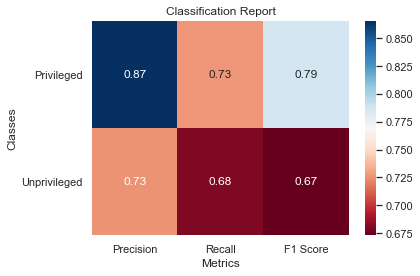

In [9]:
rw1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw1_data, privileged_attr, unpriv_attr, debiaser=rw)

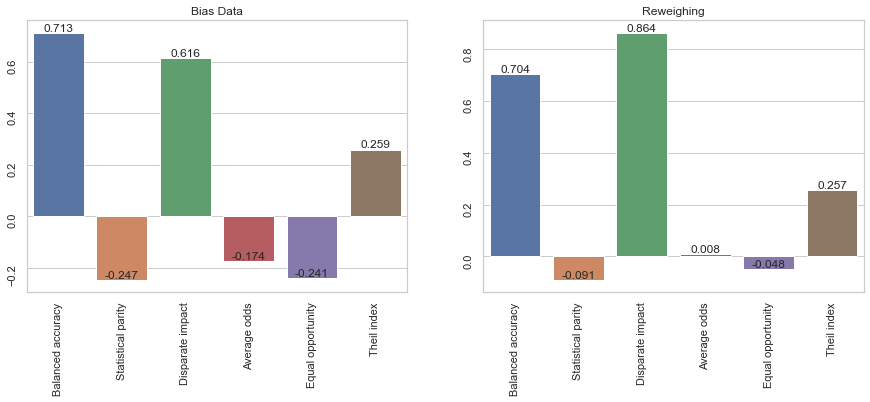

In [10]:
plot_metrics_comparison(bias1_class, rw1_class, 'Bias Data', 'Reweighing')
plt.show()

## Modified Reweighing (Sampling)

In [11]:
sampled1_data = german.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9981
Statistical Parity: -0.0013




### Classification Metrics:

Balanced accuracy: 0.7027
Statistical parity: -0.1117
Disparate impact: 0.8250
Average odds: -0.0358
Equal opportunity: -0.1031
Theil index: 0.2471


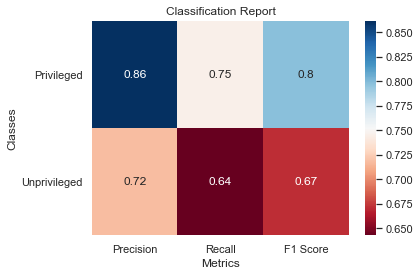

In [15]:
sampled1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled1_data, privileged_attr, unpriv_attr, debiaser=sampler, n_splits=5)

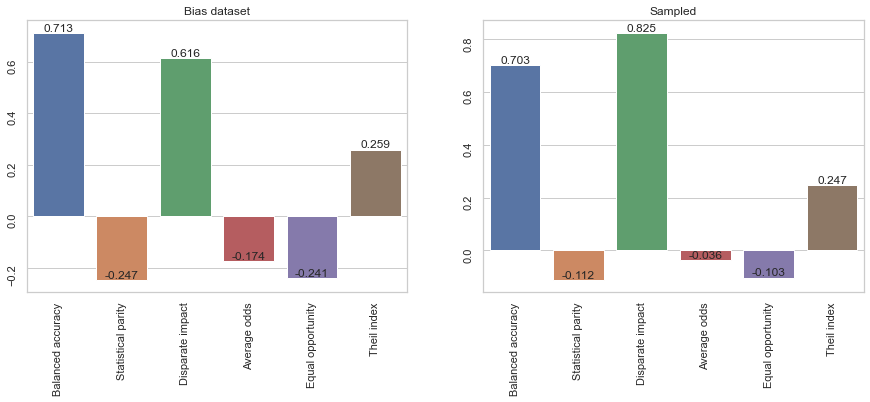

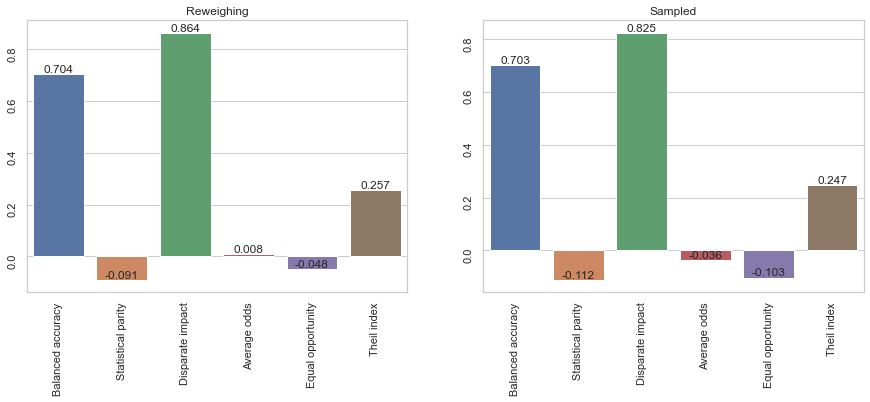

In [16]:
plot_metrics_comparison(bias1_class, sampled1_class, 'Bias dataset', 'Sampled')
plot_metrics_comparison(rw1_class, sampled1_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [17]:
scaler = MinMaxScaler(copy=False)
dir1_data = german.copy()
dir1_data.features = scaler.fit_transform(dir1_data.features)
di = DisparateImpactRemover(sensitive_attribute='age')
dir1_data = di.fit_transform(dir1_data)

### Dataset Metrics:

Disparate Impact: 0.7949
Statistical Parity: -0.1494




### Classification Metrics:

Balanced accuracy: 0.7241
Statistical parity: -0.1536
Disparate impact: 0.7549
Average odds: -0.0801
Equal opportunity: -0.1012
Theil index: 0.2497


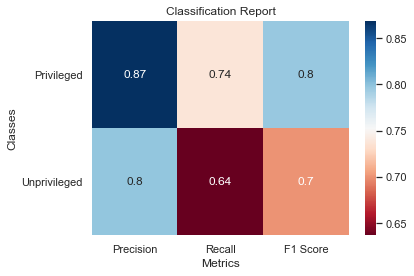

In [18]:
dir1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir1_data, privileged_attr, unpriv_attr, sensitive_attributes=['age'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


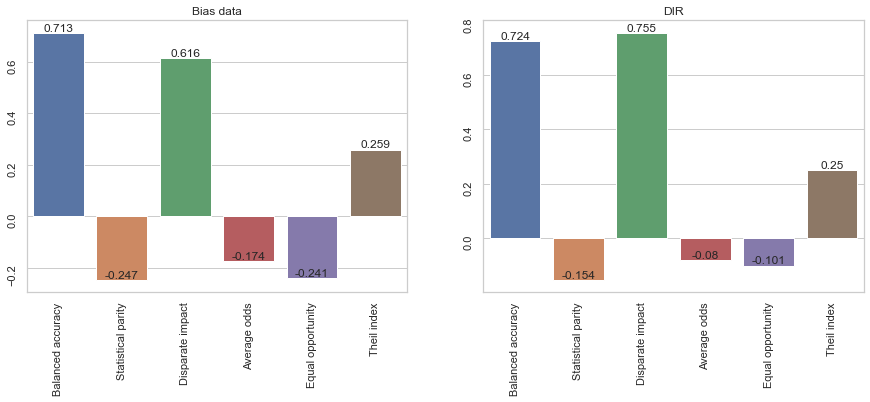

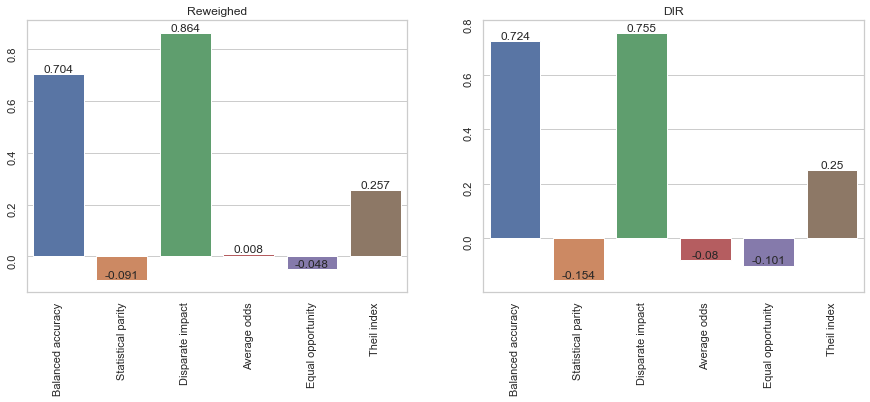

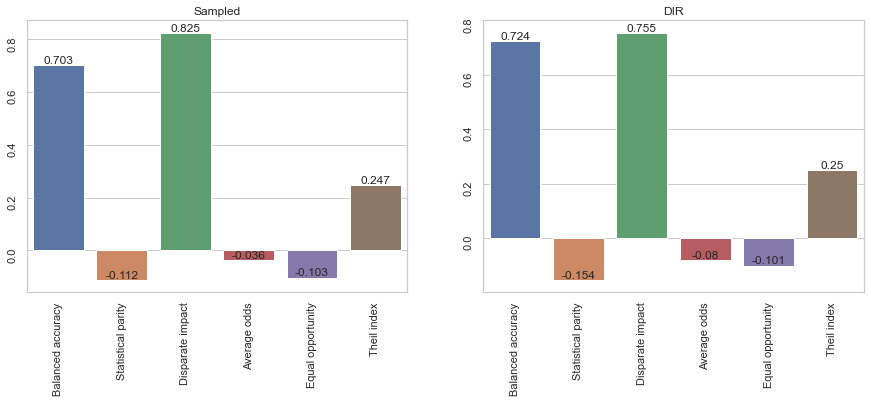

In [19]:
plot_metrics_comparison(bias1_class, dir1_class, 'Bias data', 'DIR')
plot_metrics_comparison(rw1_class, dir1_class, 'Reweighed', 'DIR')
plot_metrics_comparison(sampled1_class, dir1_class, 'Sampled', 'DIR')
plt.show()

# Reweighing + DIR

In [20]:
rw_dir1 = dir1_data.copy()
rw = Reweighing(unpriv_attr, privileged_attr)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7130
Statistical parity: -0.1228
Disparate impact: 0.8100
Average odds: -0.0435
Equal opportunity: -0.0956
Theil index: 0.2539


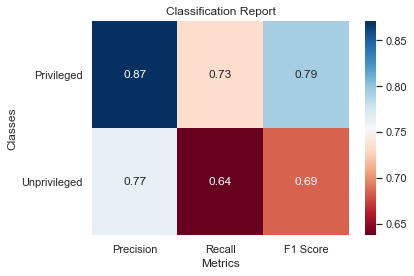

In [21]:
rw_dir1_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir1, privileged_attr, unpriv_attr, sensitive_attributes=['age'], debiaser=rw)

# Algorithms comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias,-0.1738,0.7130,0.6158,-0.2406,-0.2469,0.2593
DIR,-0.0801,0.7241,0.7549,-0.1012,-0.1536,0.2497
Reweighed,0.0080,0.7037,0.8641,-0.0480,-0.0909,0.2571
Reweighing + DIR,-0.0435,0.7130,0.8100,-0.0956,-0.1228,0.2539
Sampled,-0.0358,0.7027,0.8250,-0.1031,-0.1117,0.2471


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


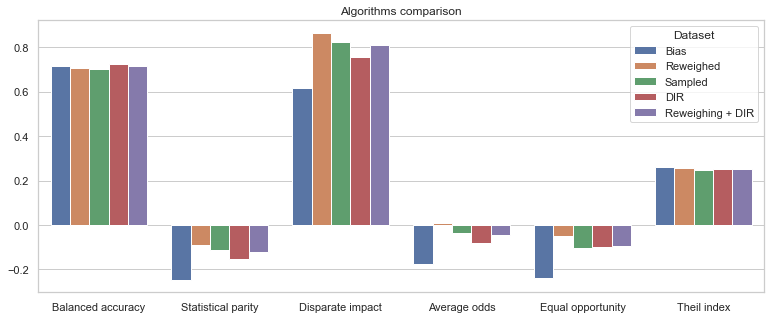

In [24]:
plot_syntesis(merge_datasets({
    'Bias': bias1_class,
    'Reweighed': rw1_class,
    'Sampled': sampled1_class,
    'DIR': dir1_class,
    'Reweighing + DIR': rw_dir1_class
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'gernam_single_syn.pdf'))
plt.show()